In [9]:
import pandas as pd
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
tqdm.pandas()

In [3]:
file_path = '../Crawl_Data/Data/yahoo_news_20241221_044513.csv'
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,TITLE,LINK,CONTENT,RELEASE_TIME,Human Label
0,0,"Tesla recall, Netflix-FIFA deal, Apple: Market...",https://finance.yahoo.com/video/tesla-recall-n...,Yahoo Finance host Rachelle Akuffo tackles thr...,3 hours ago,neutral
1,1,Elon Musk Told The U.N. If They Could Show A P...,https://finance.yahoo.com/news/elon-musk-told-...,In a world where hunger kills more people each...,9 minutes ago,neutral
2,2,"Magnificent Seven Stocks: Nvidia, Tesla Revers...",https://finance.yahoo.com/m/4205eaa9-f620-3a0b...,"Dubbed the Magnificent Seven stocks, Apple, Mi...",14 minutes ago,positive
3,3,"These Stocks Are Moving the Most Today: FedEx,...",https://finance.yahoo.com/m/57c66b45-0b6c-3ce7...,"FedEx, the shipping and logistics giant, plans...",1 hour ago,positive
4,4,Hyundai and Samsung in talks for automotive ch...,https://finance.yahoo.com/news/hyundai-samsung...,Hyundai aims to establish a domestic supply ch...,1 hour ago,neutral


In [4]:
df = df[['TITLE','CONTENT','Human Label']]
df = df.reset_index().rename(columns={'index':'Id'})
df.head()

,Id,TITLE,CONTENT,Human Label
0,0,"Tesla recall, Netflix-FIFA deal, Apple: Market...",Yahoo Finance host Rachelle Akuffo tackles thr...,neutral
1,1,Elon Musk Told The U.N. If They Could Show A P...,In a world where hunger kills more people each...,neutral
2,2,"Magnificent Seven Stocks: Nvidia, Tesla Revers...","Dubbed the Magnificent Seven stocks, Apple, Mi...",positive
3,3,"These Stocks Are Moving the Most Today: FedEx,...","FedEx, the shipping and logistics giant, plans...",positive
4,4,Hyundai and Samsung in talks for automotive ch...,Hyundai aims to establish a domestic supply ch...,neutral


In [5]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word.isalnum()]
    # remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [6]:
df['new_content'] = df['CONTENT'].progress_apply(lambda x: preprocess_text(x))

100%|██████████| 400/400 [00:09<00:00, 42.58it/s] 


In [7]:
label_mapping = {'negative':-1, 'neutral':0, 'positive':1}
df['Human Label'] = df['Human Label'].map(label_mapping).astype(int)

In [8]:
df.head()

,Id,TITLE,CONTENT,Human Label,new_content
0,0,"Tesla recall, Netflix-FIFA deal, Apple: Market...",Yahoo Finance host Rachelle Akuffo tackles thr...,0,yahoo finance host rachelle akuffo tackle thre...
1,1,Elon Musk Told The U.N. If They Could Show A P...,In a world where hunger kills more people each...,0,world hunger kill people year malaria tubercul...
2,2,"Magnificent Seven Stocks: Nvidia, Tesla Revers...","Dubbed the Magnificent Seven stocks, Apple, Mi...",1,dubbed magnificent seven stock apple microsoft...
3,3,"These Stocks Are Moving the Most Today: FedEx,...","FedEx, the shipping and logistics giant, plans...",1,fedex shipping logistics giant plan spin freig...
4,4,Hyundai and Samsung in talks for automotive ch...,Hyundai aims to establish a domestic supply ch...,0,hyundai aim establish domestic supply chain au...


## Modeling

### N-grams + TF-IDF

In [10]:
trainData = df[['new_content','Human Label']]
trainData.head()

,new_content,Human Label
0,yahoo finance host rachelle akuffo tackle thre...,0
1,world hunger kill people year malaria tubercul...,0
2,dubbed magnificent seven stock apple microsoft...,1
3,fedex shipping logistics giant plan spin freig...,1
4,hyundai aim establish domestic supply chain au...,0


In [11]:
X_text = trainData['new_content']
y_true = trainData['Human Label']

vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(X_text)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_true, test_size=0.2, random_state=42)

### Naive Bayes

In [39]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

In [40]:
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb, average='macro', zero_division=0)
nb_recall = recall_score(y_test, y_pred_nb, average='macro', zero_division=0)
print(f'NB with N-grams and TF-IDF Accuracy: {round(nb_accuracy,4)}')
print(f'NB with N-grams and TF-IDF Precision: {round(nb_precision,4)}')
print(f'NB with N-grams and TF-IDF Recall: {round(nb_recall,4)}')

NB with N-grams and TF-IDF Accuracy: 0.5125
NB with N-grams and TF-IDF Precision: 0.782
NB with N-grams and TF-IDF Recall: 0.4273


### SVM

In [41]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [42]:
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, average='macro')
svm_recall = recall_score(y_test, y_pred_svm, average='macro')
print(f'SVM with N-grams and TF-IDF Accuracy: {round(svm_accuracy,4)}')
print(f'SVM with N-grams and TF-IDF Precision: {round(svm_precision,4)}')
print(f'SVM with N-grams and TF-IDF Recall: {round(svm_recall,4)}')

SVM with N-grams and TF-IDF Accuracy: 0.5875
SVM with N-grams and TF-IDF Precision: 0.8111
SVM with N-grams and TF-IDF Recall: 0.4861


In [43]:
svm_cm = confusion_matrix(y_test, y_pred_svm)
nb_cm = confusion_matrix(y_test, y_pred_nb)

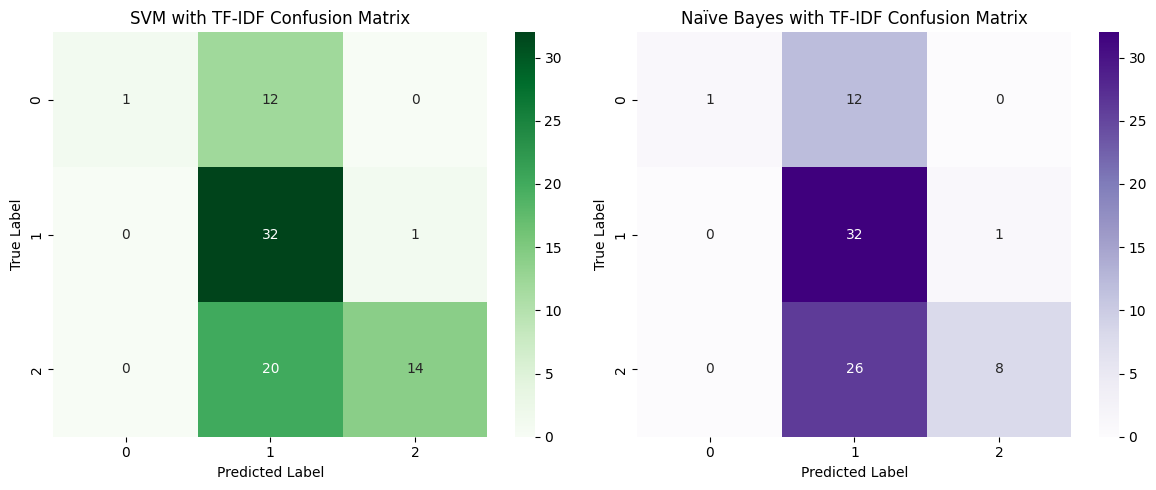

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title("SVM with TF-IDF Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Naïve Bayes Confusion Matrix
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Purples', ax=axes[1])
axes[1].set_title("Naïve Bayes with TF-IDF Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()